# Variational data assimilation with deep prior 

## Context
### Purpose
Solve data assimilation problems with implicit regularization with deep prior.

### Description
Deep image prior, a neural network with proven results in standard inverse problems, is used to determine the state of a physical system. It is a fully unsupervised model which acts as implicit regularization in the variational data assimilation metthod. The algorithm is demonstrated with a shallow-water toy model and the simulated observations are compared with variational assimilation without regularization, with Tikhonov regularization and with deep prior.

### Highlights
* Fetch the modelling codebase from the GitHub repo provided with the paper.
* Run the main Python script to generate sample observations from a shallow-water model and variational assimilation solutions.
* Recreate visualizations from the paper.
* Compare assimilation scores and smoothness statistics between the different models.

### Contributions

#### Notebook
* Mukulika Pahari (author), University of Mumbai, [@Mukulikaa](https://github.com/Mukulikaa)
* Rutika Bhoir (author), University of Mumbai, [@Rutika-16](https://github.com/Rutika-16)

#### Modelling codebase
* Arthur Filoche (author), Sorbonne Université, [@ArFiloche](https://github.com/ArFiloche)

#### Modelling publications
* Filoche, A., Béréziat, D., & Charantonis, A. (2023). Deep prior in variational assimilation to estimate an ocean circulation without explicit regularization. <i>Environmental Data Science,</i> <i>2</i>, E2. doi:10.1017/eds.2022.31

### Source code
The authors of the notebook acknowledge the original creator for providing public code available at [Deepprior4DVar_CI22](https://github.com/ArFiloche/Deepprior4DVar_CI22).

## Clone the paper's GitHub repository

The cloned repository is moved to the current directory to easily import the required Python modules.

In [ ]:
!git clone -q https://github.com/ArFiloche/Deepprior4DVar_CI22 
!mv -v Deepprior4DVar_CI22/* .
!rm -rf Deepprior4DVar_CI22

## Load libraries

In [2]:
import sys
#sys.path.append('/Users/arthur_lip6/Projets_info/Deep_prior_CI2022')

import os
import shutil

import torch
import torch.optim as optim
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

import dynamics
import utils

import _4DVar
import _DeepPrior4DVar

import tabulate
import time
import matplotlib.pyplot as plt

## Set project structure

The following directory structure is the same as given in the project repository.

In [3]:
root_dir = 'data/generated/'
save_dir = 'data/estimated/'

if os.path.exists('data'):
    shutil.rmtree('data')
    
os.makedirs(root_dir)
os.makedirs('data/results/')
os.makedirs(save_dir+'4DVar/')
os.makedirs(save_dir+'4DVar_reg/')
os.makedirs(save_dir+'4DVar_deep/')

## Generate data and run assimilations

The  `Deepprior4DVar_CI22` repo has the following main modules:
* `dynamics`: For simulating the shallow-water model.
* `_4DVar`: For assimilation with and without regularization.
* `_DeepPrior4DVar`: For assimilation with deep prior.

The repo has a script- `main.py`, to perform all the steps required to reproduce the paper. In this notebook, this script has been run with a smaller sample size to reproduce the results. The repo also contains Jupyter notebooks for demonstration in the `notebooks_demo` directory.

The first step is to generate observations from a shallow-water model initialized with initial state variables. Keeping in mind the computational limitations, the sample size has been reduced to 20 from 100, as taken in the original script. The output is stored in `data/generated`.

<div class="alert alert-block alert-info"> <b>Note: </b> You can change to the original value of n_sample=100 according to the availability of GPU resources </div>

In [4]:
n_sample=20
dx = utils.data_generator.dx
dy = utils.data_generator.dy
dynamics_obj=dynamics.SW(dx,dy)
generator=utils.DataGenerator(dynamics_obj,T=10,subsample=3,sigma=0.05)
generator.dataset(n_sample, root_dir)

The rest of the script is run as is. The next steps include:
* extracting observations from the simulated model,
* performing 4D variational assimilation with and without regularization,
* performing deep prior 4D variational assimilation,
* computing performance metrics,
  * Endpoint Error - EPE
  * Angular Error -AE
  * ||grad|| - $\|| \nabla\mathbf{w}_0\||_2$
  * ||div|| - $\|| \nabla . \mathbf{w}_0\||_2$
  * ||lap|| - $\||\Delta \mathbf{w}_0\||_2$
* storing computed metrics in a NumPy array.

In [ ]:
results=np.zeros((n_sample,4,5)) # EPE, AE, ||grad||, ||div||, ||lap||

for i in range(n_sample):
    #load data
    initial_condition=np.load(root_dir+'initial_conditions/'+'{0:04}'.format(int(i))+'.npy')
    w0_truth=torch.Tensor(initial_condition[1:,:,:])
    
    # results
    results[i,0,0]=utils.EPE(w0_truth, w0_truth) #0
    results[i,0,1]=utils.Angular_error(w0_truth, w0_truth) #0
    results[i,0,2]=utils.norm_gradw(w0_truth)
    results[i,0,3]=utils.norm_divw(w0_truth)
    results[i,0,4]=utils.norm_lapw(w0_truth)
    
    Obs=np.load(root_dir+'Obs/'+'{0:04}'.format(int(i))+'.npy')
    Obs=torch.Tensor(Obs)
    
    Rm1=torch.ones(Obs.shape)*(Obs!=0)
    Rm1=torch.Tensor(Rm1)
    
    ## 4D-Var #####
    assim = _4DVar.strong_4DVar(dynamics=dynamics_obj,
                         optimizer=optim.LBFGS([torch.zeros(0)],lr=0.75, max_iter=250))
    assim.fit(Obs=Obs,Rm1=Rm1)
    
    w0_4dvar= assim.initial_condition[1:,:,:]
    np.save(save_dir+'4DVar/'+'{0:04}'.format(int(i))+'.npy', w0_4dvar)
    
    # results
    results[i,1,0]=utils.EPE(w0_truth, w0_4dvar)
    results[i,1,1]=utils.Angular_error(w0_truth, w0_4dvar)
    results[i,1,2]=utils.norm_gradw(w0_4dvar)
    results[i,1,3]=utils.norm_divw(w0_4dvar)
    results[i,1,4]=utils.norm_lapw(w0_4dvar)
    
    ## Thikonov 4D-Var #####
    smoothreg= _4DVar.smooth_regul(alpha=5e3, beta=5e2,dx=dx,dy=dy)
    assim = _4DVar.strong_4DVar(dynamics=dynamics_obj, regul=smoothreg,
                         optimizer=optim.LBFGS([torch.zeros(0)],lr=0.75, max_iter=250))
    assim.fit(Obs=Obs,Rm1=Rm1)
    
    w0_4dvar_reg=assim.initial_condition[1:,:,:]
    np.save(save_dir+'4DVar_reg/'+'{0:04}'.format(int(i))+'.npy', w0_4dvar_reg)
    
    # results
    results[i,2,0]=utils.EPE(w0_truth, w0_4dvar_reg)
    results[i,2,1]=utils.Angular_error(w0_truth, w0_4dvar_reg)
    results[i,2,2]=utils.norm_gradw(w0_4dvar_reg)
    results[i,2,3]=utils.norm_divw(w0_4dvar_reg)
    results[i,2,4]=utils.norm_lapw(w0_4dvar_reg)
    
    ## Deep prior 4D-Var #####
    netG = _DeepPrior4DVar.Generator()
    netG.apply(_DeepPrior4DVar.weights_init)
    
    noise = torch.randn(netG.nz, 1, 1)
    
    assim=_DeepPrior4DVar.deeprior_strong_4DVar(generator=netG, dynamics=dynamics_obj,
                               lr = 0.002, beta1 = 0.5, n_epoch=2000)
    assim.fit(noise, Obs, Rm1)
    
    w0_4dvar_deep=assim.initial_condition[1:,:,:]
    np.save(save_dir+'4DVar_deep/'+'{0:04}'.format(int(i))+'.npy', w0_4dvar_deep)
    
    # results
    results[i,3,0]=utils.EPE(w0_truth, w0_4dvar_deep)
    results[i,3,1]=utils.Angular_error(w0_truth, w0_4dvar_deep)
    results[i,3,2]=utils.norm_gradw(w0_4dvar_deep)
    results[i,3,3]=utils.norm_divw(w0_4dvar_deep)
    results[i,3,4]=utils.norm_lapw(w0_4dvar_deep)
    
    elapsed = time.perf_counter() - time_start
    print(f'Sample {i} successfully run and stored in {elapsed //60} min')

np.save('./data/results/main.npy',results)

## Visualisation

The data generated from the script is loaded into variables for visualization. The plots are made with the scripts provided in `utils`. 

In [8]:
i=0
root_dir='data/generated/'

initial_condition=np.load(root_dir+'initial_conditions/'+
                          '{0:04}'.format(int(i))+'.npy')
Obs=np.load(root_dir+'Obs/'
                          +'{0:04}'.format(int(i))+'.npy')

results=np.load('data/results/main.npy')

#### Initial conditions (Figure 2)

The plot below shows the evolution of the simulated system. State variables of the considered system are $\eta$, the height deviation of the horizontal pressure surface from its mean height, and $w$, the associated velocity field. The considered temporal window $T$ has a fixed size, in this case equal to 10.

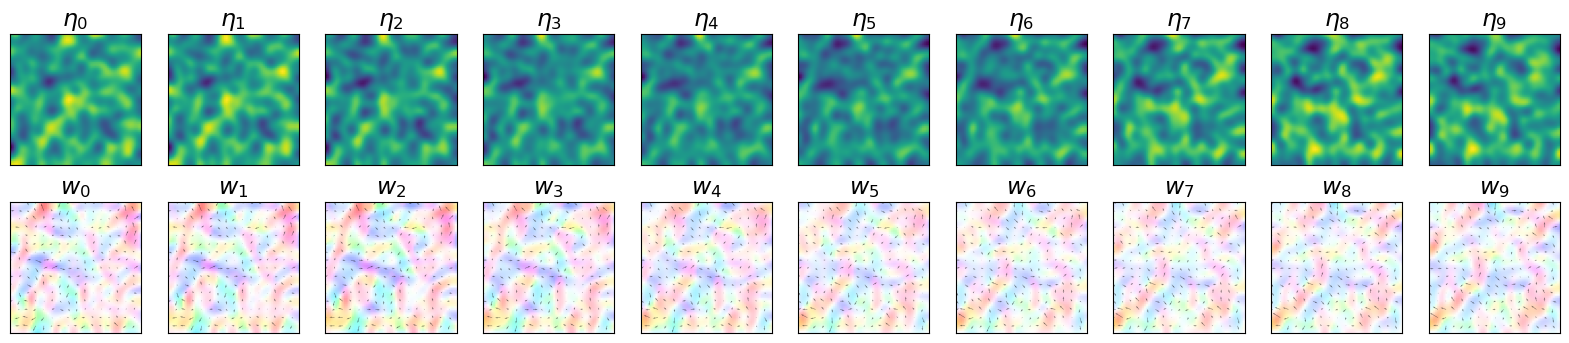

In [9]:
T=10    # Assimilation window size

X = torch.Tensor(initial_condition)
plt.figure(figsize=(20,4))
for t in range(T):
        
    plt.subplot(2,T,t+1)
    plt.title('$\eta_{'+str(t)+'}$',fontsize=17)
    plt.yticks([])
    plt.xticks([])

    plt.imshow(X[0,:,:])
    plt.subplot(2,T,T+t+1)
    utils.plot_w(X[1,:,:],X[2,:,:],quiver=True,title='w_'+str(t),q_scale=2.5)
    plt.title('$w_{'+str(t)+'}$',fontsize=17)
    
    X=dynamics_obj.forward(X)

#### Observations with noise (Figure 3)

The plot below shows the observations extracted from the simulated system and infused with noise.

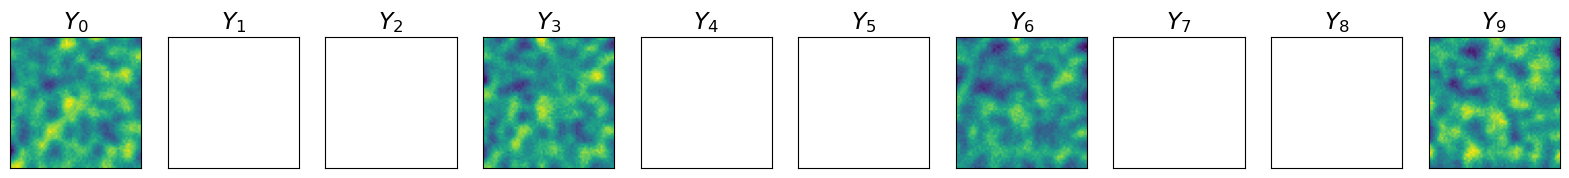

In [10]:
subsample=3    # Subsampling frequency
 
plt.figure(figsize=(20,4))

for t in range(T):
        
    plt.subplot(1,T,t+1)
    plt.title('$Y_{'+str(t)+'}$',fontsize=17)
    if t%subsample==0:
        plt.imshow(Obs[t,0,:])
    else :
        plt.imshow(float(np.nan)*Obs[t,0,:])
    plt.yticks([])
    plt.xticks([])

plt.show()

#### Results

The following plots represent the dynamical state of the system through the different assimilation approaches and the observed state. It is a reconstruction of [Figure 4](https://static.cambridge.org/binary/version/id/urn:cambridge.org:id:binary:20230110163855547-0883:S2634460222000310:S2634460222000310_fig4.png) in the paper.

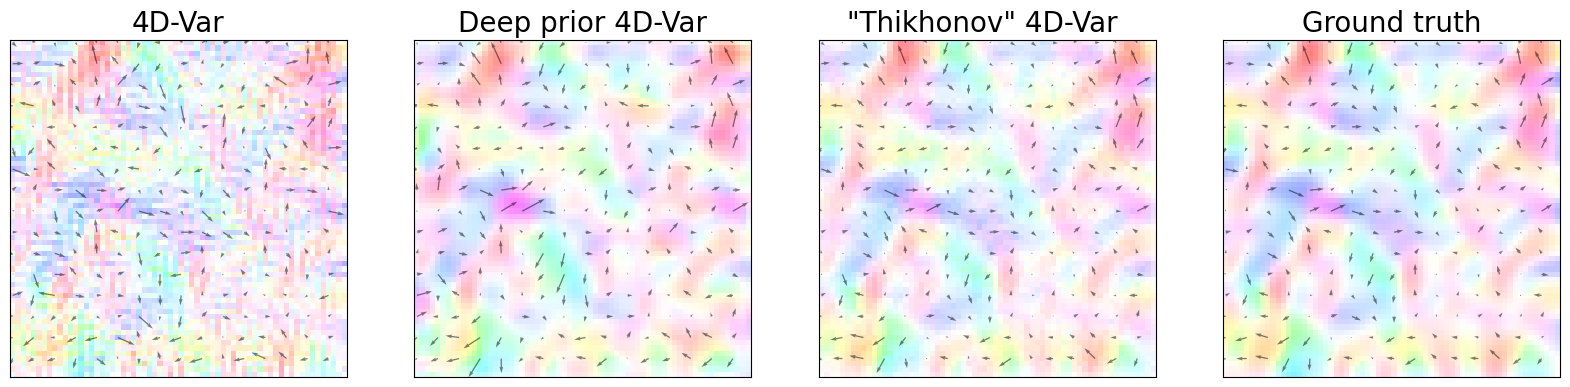

In [11]:
save_dir = 'data/estimated/'

w0_truth=initial_condition[1:,:,:]

w0_4dvar=np.load(save_dir+'4DVar/'+'{0:04}'.format(int(i))+'.npy')
w0_4dvar_reg=np.load(save_dir+'4DVar_reg/'+'{0:04}'.format(int(i))+'.npy')
w0_4dvar_deep=np.load(save_dir+'4DVar_deep/'+'{0:04}'.format(int(i))+'.npy')

u0_truth=torch.Tensor(w0_truth[0,:,:])
v0_truth=torch.Tensor(w0_truth[1,:,:])
    
u0_4dvar=torch.Tensor(w0_4dvar[0,:,:])
v0_4dvar=torch.Tensor(w0_4dvar[1,:,:])

u0_4dvar_reg=torch.Tensor(w0_4dvar_reg[0,:,:])
v0_4dvar_reg=torch.Tensor(w0_4dvar_reg[1,:,:])

u0_4dvar_deep=torch.Tensor(w0_4dvar_deep[0,:,:])
v0_4dvar_deep=torch.Tensor(w0_4dvar_deep[1,:,:])

normalization = True
quiver = True
q_alpha = 0.5
q_scale =2.5
sub=4

plt.figure(figsize=(20,10))
    
plt.subplot(1,4,1)
utils.plot_w(u0_4dvar,v0_4dvar,
       normalization=normalization,
       quiver=quiver, q_alpha=q_alpha,q_scale=q_scale,
       title = '4D-Var')
plt.title('4D-Var',fontsize=20)

plt.subplot(1,4,2)
utils.plot_w(u0_4dvar_deep,v0_4dvar_deep,
       normalization=normalization,
       quiver=quiver, q_alpha=q_alpha,q_scale=q_scale,
       title = 'Deep prior 4D-Var')
plt.title('Deep prior 4D-Var',fontsize=20)

plt.subplot(1,4,3)
utils.plot_w(u0_4dvar_reg,v0_4dvar_reg,
       normalization=normalization,
       quiver=quiver, q_alpha=q_alpha,q_scale=q_scale,
       title = '4D-Var + Thikhonov')
plt.title('"Thikhonov" 4D-Var ',fontsize=20)

plt.subplot(1,4,4)
utils.plot_w(u0_truth,v0_truth,
       normalization=normalization,
       quiver=quiver, q_alpha=q_alpha,q_scale=q_scale,
       title = '')
plt.title('Ground truth',fontsize=20)

plt.show()

#### Metrics (Figure 5)

The following plots compare the different algorithms with respect to the five metrics as mentioned in the paper:
* Endpoint error
* Angular error
* Smoothness statistics

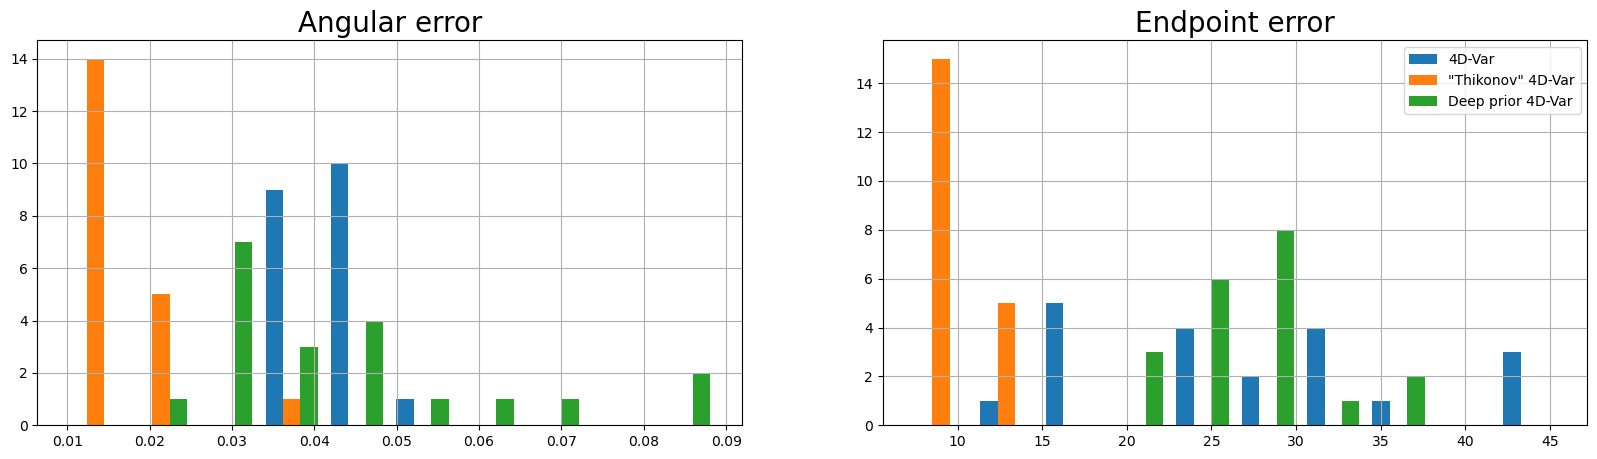

In [12]:
bins=10
plt.figure(figsize=(20,5))

titles=["Endpoint error","Angular error"]
for i in range(0,2):
    plt.subplot(1,2,i+1)
    
    plt.hist([results[:,j,i] for j in range(1, 4)], 
             bins, label=['4D-Var','"Thikonov" 4D-Var', 'Deep prior 4D-Var'])
    if i == 1:
        plt.legend(loc='upper right')
    plt.title(titles[i-1],fontsize=20)
    plt.grid()
plt.show()

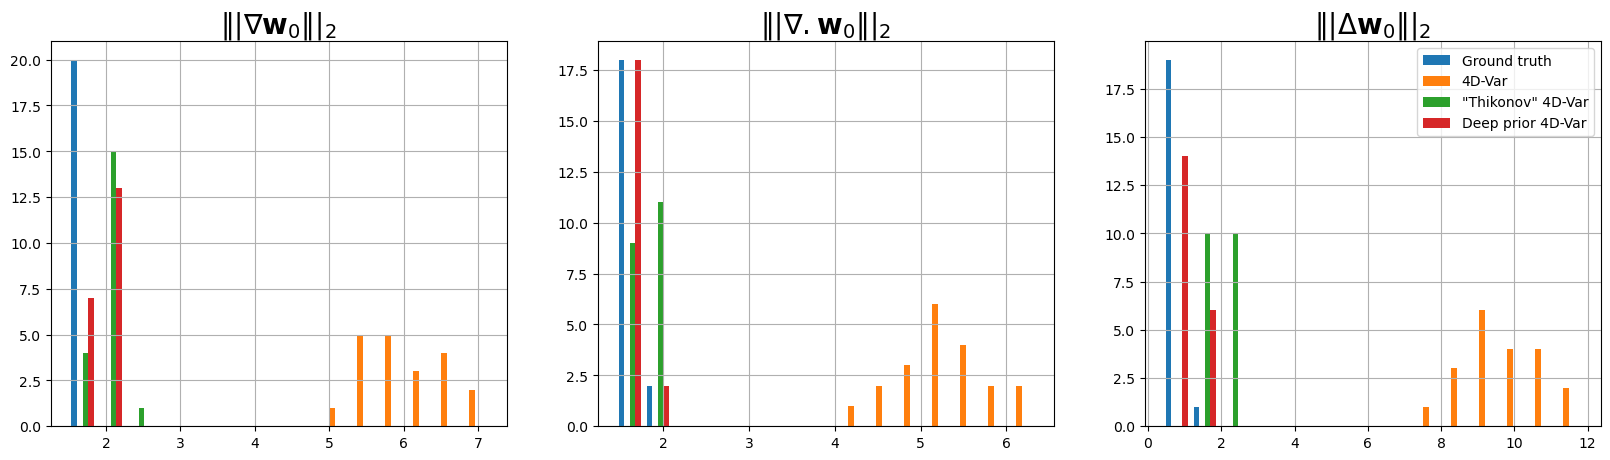

In [13]:
bins=15
plt.figure(figsize=(20,5))

titles=[r"$\|| \nabla\mathbf{w}_0\||_2$",r"$\|| \nabla . \mathbf{w}_0\||_2$",'$\||\Delta \mathbf{w}_0\||_2$']
for i in range(2,results.shape[2]):
    plt.subplot(1,3,i-1)
    
    plt.hist([results[:,j,i] for j in range(4)], 
             bins, label=['Ground truth', '4D-Var','"Thikonov" 4D-Var', 'Deep prior 4D-Var'])
    if i == 4:
        plt.legend(loc='upper right')
    plt.title(titles[i-2],fontsize=20)
    plt.grid()

plt.show()

The following table is a direct comparison between the metrics. They are within the limits of the error rates as mentioned in [Table 1](https://static.cambridge.org/binary/version/id/urn:cambridge.org:id:binary:20230110163855547-0883:S2634460222000310:S2634460222000310_tab1.png).

In [14]:
table_format = "grid"
table = [
    ["Metrics", "Ground truth", "4D-Var", "'Thikonov' 4D-Var", "Deep prior 4D-Var"],
    ["EPE", results.mean(axis=0)[0, 0], results.mean(axis=0)[1, 0], results.mean(axis=0)[2, 0], results.mean(axis=0)[3, 0]],
    ["Angular error", results.mean(axis=0)[0, 1], results.mean(axis=0)[1, 1], results.mean(axis=0)[2, 1], results.mean(axis=0)[3, 1]],
    ["||grad||", results.mean(axis=0)[0, 2], results.mean(axis=0)[1, 2], results.mean(axis=0)[2, 2], results.mean(axis=0)[3, 2]],
    ["||div||", results.mean(axis=0)[0, 3], results.mean(axis=0)[1, 3], results.mean(axis=0)[2, 3], results.mean(axis=0)[3, 3]],
    ["||lap||", results.mean(axis=0)[0, 4], results.mean(axis=0)[1, 4], results.mean(axis=0)[2, 4], results.mean(axis=0)[3, 4]],
]


formatted_table = tabulate.tabulate(table, headers="firstrow", tablefmt=table_format)

print(formatted_table)

+---------------+----------------+------------+---------------------+---------------------+
| Metrics       |   Ground truth |     4D-Var |   'Thikonov' 4D-Var |   Deep prior 4D-Var |
+===============+================+============+=====================+=====================+
| EPE           |     0          |  0.0417896 |            0.015174 |           0.0443217 |
+---------------+----------------+------------+---------------------+---------------------+
| Angular error |     0.00542219 | 28.3352    |            9.68662  |          27.0093    |
+---------------+----------------+------------+---------------------+---------------------+
| ||grad||      |     1.64585    |  6.05524   |            1.97998  |           1.92632   |
+---------------+----------------+------------+---------------------+---------------------+
| ||div||       |     1.60069    |  5.25963   |            1.79939  |           1.62848   |
+---------------+----------------+------------+---------------------+-----------

## Challenges and improvements

* While most cloud-based notebook servers come with pre-installed packages, it will be helpful to include an environment file in the codebase to aid local runs.
* The codebase is modularized and easy to understand but a brief outline in the Readme file would be useful.

## Summary


* The results in the paper "Deep prior in variational assimilation to estimate an ocean circulation without explicit regularization" can be correctly reproduced with the help of the materials provided with the paper. 
* This paper encourages the use of deep learning techniques in traditional inverse problems which are a basis for many geoscience modelling experiments.
* PyTorch is used for running the assimilation models and NumPy is used to store the results.
* Matplotlib is used for all visualizations.
* Possible improvements include add an environment file and a comprehensive README file to support the modelling codebase. 

## Additional information
**Dataset**: All data is generated at runtime.

**Codebase**: https://github.com/ArFiloche/Deepprior4DVar_CI22 - commit 83961da on the main branch.

**License**: The code in this notebook is licensed under the MIT License. The Environmental Data Science book is licensed under the Creative Commons by Attribution 4.0 license. See further details [here](https://github.com/alan-turing-institute/environmental-ds-book/blob/master/LICENSE.md).

**Contact**: If you have any suggestion or report an issue with this notebook, feel free to [create an issue](https://github.com/alan-turing-institute/environmental-ds-book/issues/new/choose) or send a direct message to [environmental.ds.book@gmail.com](mailto:environmental.ds.book@gmail.com).

In [15]:
from datetime import date
print(f'Last tested: {date.today()}')

Last tested: 2023-09-12
